# Inf2 - Foundations of Data Science
## Semester 2 Week 04: Logistic regression

**Learning outcomes:** In this lab you will learn about logistic regression, interpretation of logistic regression coefficients and generating confidence intervals for logistic regression coefficients. By the end of this lab you should be able to:

- identify what transformations would be helpful to variables before applying logistic regression
- apply logistic regression to a dataset
- interpret the coefficients from application of logistic regression
- apply the bootstrap to logistic regression to obtain confidence intervals
- interpret the confidence intervals

The lecture topic on "Logistic regression" will be helpful background to this lab.

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


## Logistic regression

We will look at the credit approval dataset, which we have already looked at during the lectures, and we will try to reconstruct the results ourselves. Our goal is to use logistic regression to understand what features are most important in the decision of giving an applicant a credit.

**Exercise 01:** The first step is to clean our dataset.
- Load the dataset.
- Display the first 20 entries.
- Replace all values, which are non-numeric by reasonable numeric values.
- For simplicity, drop the `ZipCode` column. Remark: Zip codes can have an impact on credit approval. For example, ML algorithms trained on racially biased data, where the information about race has been dropped, can still learn the bias, as people from same ethnical background tend to live in the same area. However, for logistic regression, where the numerical value is important, the zip code will not provide any information, as a zip code with just a single different digit, can be many miles apart.
- Remove all entries with NaN values (Hint: This data set has `?` characters insted of NaN values).
**JF: What do we do with the other columns?**

In [10]:
# Your answer
credit = pd.read_csv('datasets/Credit_Approval.csv', na_values=['?'])
credit.replace('+', 1, inplace=True)
credit.replace('-', 0, inplace=True)
credit.replace('?', pd.NA, inplace=True)
credit['Gender']=credit['Gender'].replace('a', 0)
credit['Gender']=credit['Gender'].replace('b', 1)
credit['Employed']=credit['Employed'].replace('f', 0)
credit['Employed']=credit['Employed'].replace('t', 1)
credit['PriorDefault']=credit['PriorDefault'].replace('f', 0)
credit['PriorDefault']=credit['PriorDefault'].replace('t', 1)
credit.drop(['ZipCode'], 1, inplace=True)
credit.dropna(inplace=True)
credit.head(20)
credit.BankCustomer.unique()

array(['g', 'p', 'gg'], dtype=object)

**Exercise 02:** Let's compare the values for the two genders. Compute the mean of the columns for each gender.

In [12]:
credit.groupby('Gender').mean()

,Age,Debt,YearsEmployed,PriorDefault,Employed,CreditScore,ZipCode,Income,Approved
Gender,,,,,,,,,
0.0,30.760985,5.090591,1.818498,0.551724,0.487685,2.625616,160.926108,911.389163,0.467980
1.0,31.838911,4.711767,2.436378,0.526667,0.417778,2.446667,189.126667,1059.942222,0.446667


**Exercise 03:** Create a pairplot of the data, colouring differently approved and denied entries. **JF: You dropped some columns. Is there a reason for it?**

<Figure size 432x432 with 0 Axes>

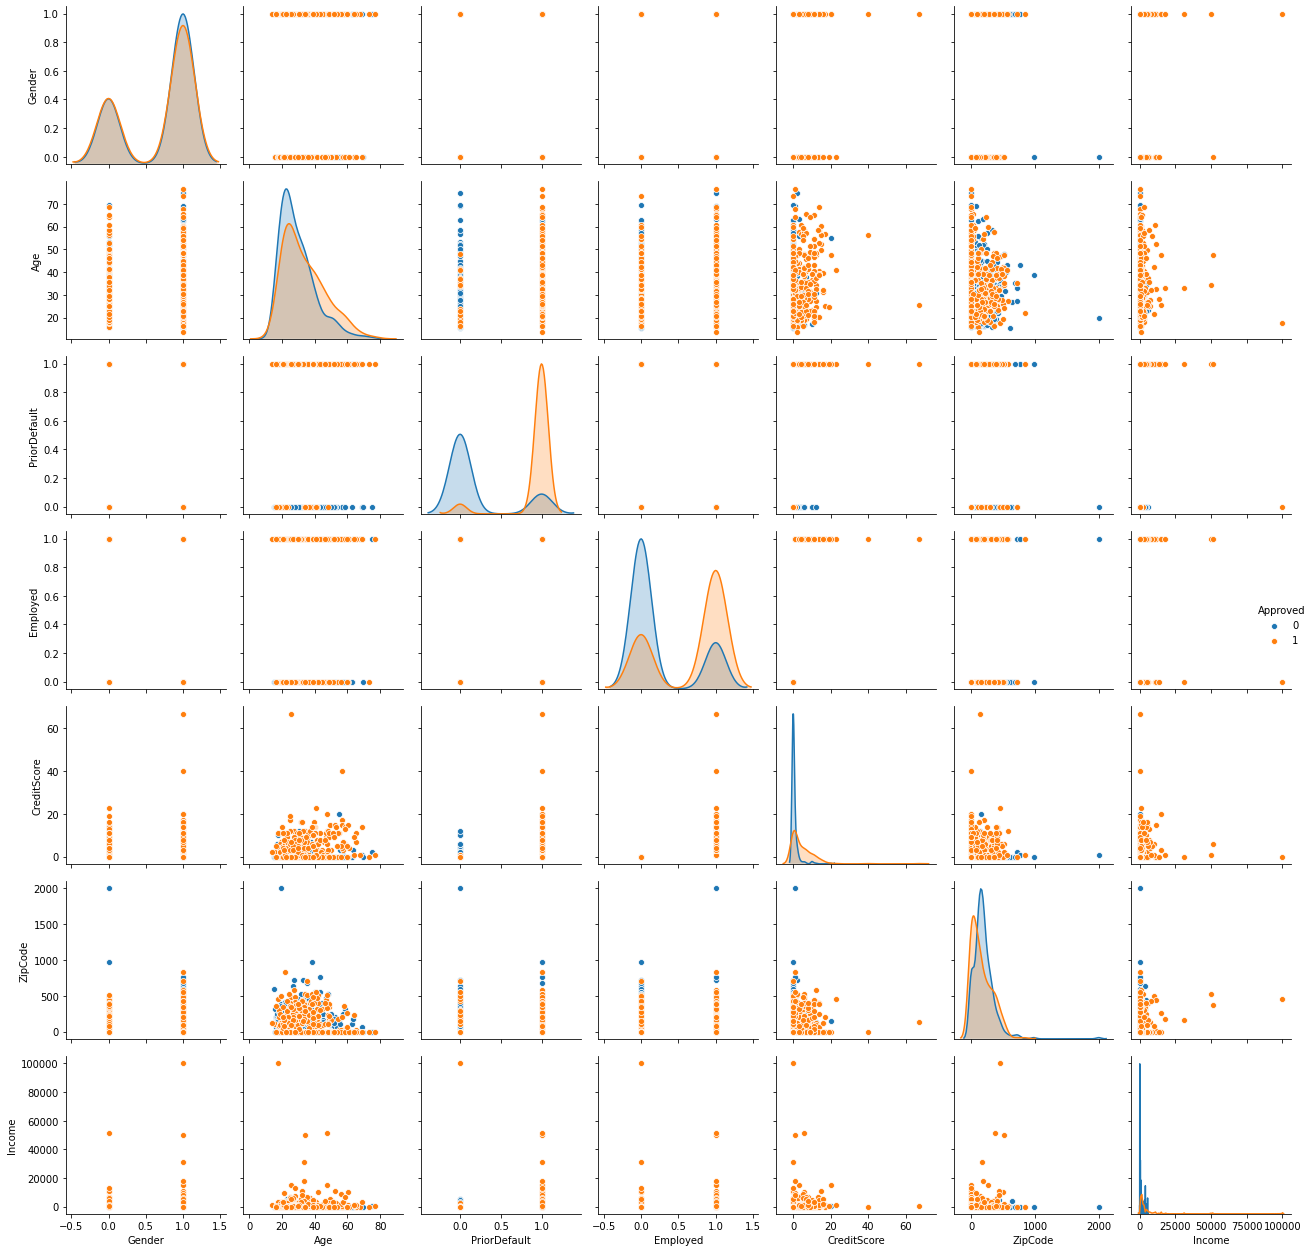

In [11]:
# Your code
plt.figure(figsize=(6,6))
sns.pairplot(credit.drop(['Debt', 'YearsEmployed'], 1), hue='Approved')
plt.tight_layout()

## Transform the dataset so logistic regression works better

**Discussion:** We have already applied the log transform to datasets previously. Can you remember, why this can be helpful? On which variables in your dataset would a log transform help. Have a look at the plot above.

Your answer:
- If the data is skewed, a log-transformation can help to reshape the data in more normal form.
- Both Income and Credit score seem very skewed.

**Excercise:** 
- Replace the `Income` variable with a log transformed version called `LogIncome`.
- Replace the `CreditScore` variable with a log transformed version called `LogCreditScore`.
- What's the problem with a log transform? **JF I don't understand the question**
- Fix the problem by the transform `log(x) + 1`

In [13]:
# Your answer
credit['LogIncome'] = np.log10(credit['Income'] + 1)
credit['LogCreditScore'] = np.log(credit['CreditScore'] + 1)
credit.drop(['Income', 'CreditScore'], 1, inplace=True)

## Use sk-learn to run Logistic regression

**Exercise:** Let's start with the simplest case of logistic regression. We want to know whether age alone is a good feature to predict whether someone receives a credit. 
- Use the `LogisticRegression()` to run logistic regression. (Hint: You will have to supply a numpy matrix of independent variables and a vector of response variables - the Nearest Neighbours lab may remind you how to do it.)
- Store the fitted model. **JF: I don't know what clf stands for and I really dislike acronyms**
- Store the intercept and the coefficient of the model in `beta0` and `beta1`, respectively. Print the values.
- Create a scatterplot, where you randomly sample 50 data points. The x-axis should be `Age` and the y-axis should be `Approved`.
**JF: Is there a reason you have sorted the data based on Age?**
- Add a line plot to your figure that shows the model. **JF: Why do we use predict_proba, couldn't we just use beta0+ x * beta1 ?**

Beta 0: -1.1764552274346411, Beta 1: 0.03133241735434469


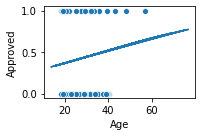

In [18]:
X = credit[['Age']].to_numpy(copy=True) 
y = credit['Approved'].to_numpy()
model = LogisticRegression(random_state=0).fit(X, y)
beta0 = model.intercept_[0]
beta1 = model.coef_[0][0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))
plt.figure(figsize=(3, 2))

sns.scatterplot(x='Age', y='Approved', data=credit.sample(50, random_state=1))
plt.plot(X, model.predict_proba(X)[:,1])

plt.tight_layout()

**Exercise:** Interpret the intercept `clf.intercept_`. What quantity does it represent? Describe the characteristics of the passenger for who the independent variables are all zero. Does such a passenger exist?

In [ ]:
clf.intercept_

Your answer:

This is the log odds of survival of a newborn female in "zeroeth class" with no siblings and no parents aboard, who paid no fare. It shows that this hypothetical passenger was $e^{3.701}=40.5$ times more likely to survive than die.

**Exercise:** Interpret the coefficients `clf.coef_`. You may find it helpful to convert the output from sklearn back into a pandas Series with an index. Try to use language that you think would be understandable by a general audience. [DCS whacky idea: Paste it into the form here: we will have a poll to decide who made the most understandable interpretation.]

In [ ]:
coeffs = pd.Series(clf.coef_[0], index=titanic_trans.columns.drop('Survived'))

In [ ]:
coeffs

In [ ]:
np.exp(coeffs)

Your answer:

All other things being equal:
- For each class higher, passengers were about 2.6 times (1/0.386) more likely to survive than not - i.e. 1st class passengers were 2.6 times as likely to survive as second class passengers
- Men were 13.6 times less likely to survive than women
- Every year of age meant that your odds of survival to drowning went down by about 4%
- For every sibling or spouse aboard, your odds of survival decreased by a factor of 1.6
- For every sibling or spouse aboard, your odds of survival decreased by a factor of 1.82
- A passenger who paid £100 was 2.5 times as likely to survive as one who paid £10.  

## How many of these coefficients are meaningful?

How likely is it that some of these coefficients could have arisen by chance? We'd like to find confidence intervals for each coefficient. 

**Excercise:** Write a bootstrap function to generate the sampling distribution of all of the coefficients. On each bootstrap iteration, we'd like to store the values of the intercept and all of the coefficients in one row of a dataframe. We'll then be able to plot distribution of the dataframe, and compute confidence intervals from the marginal distributions. We suggest you follow the pattern in the previous lab, and write:
1. A function that takes a dataframe with the same column names as the titanic dataset, fits a logistic regression model to the dataset and returns a pandas series containing the intercept and coefficients from the logistic regression
2. A bootstrap function that takes the above function as `estimator` arguments, and, on each bootstrap replications stores the coefficients in the row of a data frame. It should return the bootstrap samples as a dataframe with an `Intercept` column and then one column for each independent variable. The function doesn't need to return the quantiles or the bootstrap standard error. Note that the column types of the data frame should be `float`.

You can test the first function by making sure it gives you the same results as when you ran the logistic regression on the Titanic dataset above.  Once you've written the function, try it out on the Titanic dataset. You can use the `.quantile()` function on the returned data frame to compute the quantiles. You can also look at a pairplot of the bootstrap samples.

**Note** You may get some warnings from `LogisticRegression` when running the bootstrap. Don't worry about them for now.

In [ ]:
# Your answser

def titanic_lr(titanic_trans):
    X = titanic_trans.drop('Survived', 1).to_numpy(copy=True) 
    y = titanic_trans['Survived'].to_numpy()
    clf = LogisticRegression().fit(X, y)
    coeffs = pd.Series(clf.intercept_, index=['Intercept'])
    coeffs = coeffs.append(pd.Series(clf.coef_[0], index=titanic_trans.columns.drop('Survived')))
    return(coeffs)

In [ ]:
coeffs = titanic_lr(titanic_trans)

In [ ]:
def bootstrap_df(df, k=1000, estimator=titanic_lr):    
    ## Main part of bootstrap
    n = len(df)
    coeffs = estimator(df)
    x_star_est = pd.DataFrame(index=range(k), columns=coeffs.index, dtype='float')
    for i in range(k):
        x_star = df.sample(n, replace=True)
        coeffs_star = estimator(x_star)      
        x_star_est.loc[i] = coeffs_star
    
    return(x_star_est)

In [ ]:
coeffs_bs = bootstrap_df(titanic_trans)

In [ ]:
coeffs_bs.quantile([0.025, 0.975])

In [ ]:
sns.pairplot(coeffs_bs)

**Discussion** What can you conclude from the quantiles? Are any of the relationships you identified earlier open to question, because they may have arisen by chance?

## Fixing the errors

Logistic regression works better with standardised quantities. We can standardise the independent variables and then try fitting logistic regression again. However, the resulting coefficients will themselves be standardised, so we'll need to transform them back, to obtain the true figures. We suggest you just standardise `Age` and `LogFare`. After running the same bootstrap function as above on the transformed data you can transform the parameters back using the formulae $\beta_{Age} = b_{Age}/s_{Age}$, where $b_{Age}$ is the transformed coefficient returned when the bootstrap function is applied to the transformed data. 

In [ ]:
titanic_trans_std = titanic_trans.copy()

In [ ]:
s = titanic_trans_std.std()
xbar = titanic_trans_std.mean()
titanic_trans_std['Age'] = titanic_trans_std['Age'].transform(lambda x: (x - xbar['Age'])/s['Age'])
titanic_trans_std['LogFare'] = titanic_trans_std['LogFare'].transform(lambda x: (x - xbar['LogFare'])/s['LogFare'])

In [ ]:
x_star = bootstrap_df(titanic_trans_std)
x_star['Intercept'] = x_star['Intercept'] - x_star['Age']*xbar['Age']/s['Age'] - x_star['LogFare']*xbar['LogFare']/s['LogFare']
x_star['Age'] = x_star['Age']/s['Age']
x_star['LogFare'] = x_star['LogFare']/s['LogFare']

In [ ]:
sns.pairplot(x_star)

In [ ]:
x_star.quantile([0.025, 0.975])